In [1]:
import csv
import os
from typing import Dict, List, Union

import numpy as np
import pandas as pd
from tqdm import tqdm

from ex_params import (
    DATA_AI_PATH,
    DATA_HUMAN_PATH,
    DATASETS,
    DATASETS_PATH,
    STATS_PATH,
    SEED,
    BASELINE_MODELS
)
from ex_utils import get_csv_paths
from models import BaselineClassifier

In [2]:
import math
import matplotlib.pyplot as plt

In [3]:
warmup_steps = 1000
max_steps = 4000
def get_lr(it):
    if it < warmup_steps:
        return max_lr * (it + 1) / warmup_steps

    if it > max_steps:
        return min_lr

    decay_ratio = (it - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= decay_ratio <= 1
    coeff = 1.0 - decay_ratio  # Linearly decays from 1 to 0
    return min_lr + coeff * (max_lr - min_lr)

In [15]:
max_lr = 5e-5
min_lr = max_lr * 0.1
lrs_mini = [get_lr(it) for it in range(10000)]

In [16]:
max_lr = 3e-5
min_lr = max_lr * 0.1
lrs_small = [get_lr(it) for it in range(10000)]

In [17]:
max_lr = 2e-5
min_lr = max_lr * 0.1
lrs_medium = [get_lr(it) for it in range(10000)]

In [18]:
max_lr = 1e-5
min_lr = max_lr * 0.1
lrs_large = [get_lr(it) for it in range(10000)]

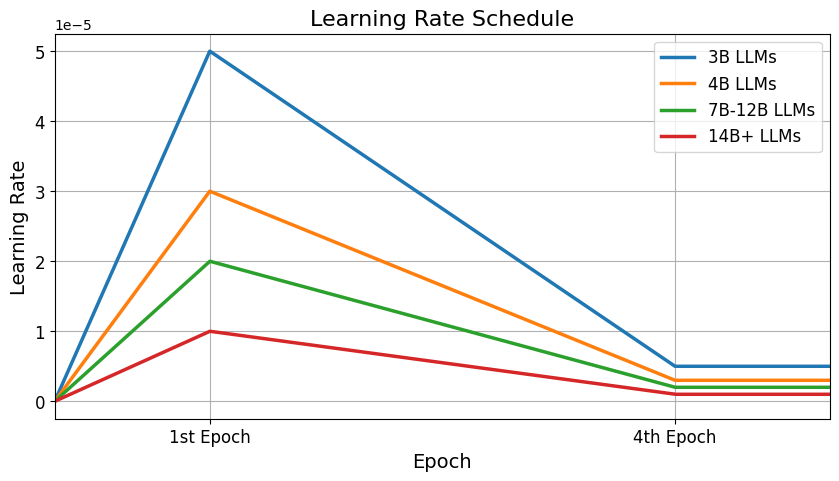

In [21]:
plt.figure(figsize=(10, 5))
plt.title("Learning Rate Schedule", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Learning Rate", fontsize=14)
plt.xlim(0, 5000)

# Plotting the learning rates with increased linewidth
plt.plot(lrs_mini, label="3B LLMs", linewidth=2.5)
plt.plot(lrs_small, label="4B LLMs", linewidth=2.5)
plt.plot(lrs_medium, label="7B-12B LLMs", linewidth=2.5)
plt.plot(lrs_large, label="14B+ LLMs", linewidth=2.5)

# Set custom x-axis ticks
plt.xticks([1000, 4000], ["1st Epoch", "4th Epoch"], fontsize=12)
plt.yticks(fontsize=12)

# Legend font size and line width reflected from plots
plt.legend(fontsize=12)
plt.grid()
plt.show()


In [28]:
import tiktoken
tokenizer = tiktoken.get_encoding("o200k_base")  # cl100k_base
from nltk.tokenize import sent_tokenize, word_tokenize
from typing import List, Tuple

In [29]:
def calc_stats(
    texts: List[str], tokenizer: tiktoken
) -> Tuple[List[List[int]], int, int, int, int, int]:
    results = []
    total_sentences, total_words, total_chars, total_tokens = 0, 0, 0, 0
    total_samples = len(texts)

    for text in tqdm(texts):
        text_words = 0
        text_chars = 0
        text_tokens = tokenizer.encode(text)
        sentences = sent_tokenize(text)
        for sentence in sentences:
            words = word_tokenize(sentence)
            text_words += len(words)
            text_chars += sum([len(word) for word in words])

        total_sentences += len(sentences)
        total_words += text_words
        total_chars += text_chars
        total_tokens += len(text_tokens)

        results.append([len(sentences), text_words, text_chars, len(text_tokens)])
    return (
        results,
        total_samples,
        total_sentences,
        total_words,
        total_chars,
        total_tokens,
    )

In [54]:
df = pd.read_csv(os.path.join(DATASETS_PATH, "master-testset-hard/test5.csv"))
texts = df["text"].tolist()

In [55]:
results, num_samples, num_sentences, num_words, num_chars, num_tokens = (
    calc_stats(texts, tokenizer)
)

100%|██████████| 10000/10000 [00:15<00:00, 633.11it/s]


In [56]:
num_samples, num_sentences, num_tokens

(10000, 113145, 2469945)

In [30]:
df1 = pd.read_csv(TRAINING_HISTORY_PATH + "baseline/training_history_baseline_large_master-mini.csv")
df2 = pd.read_csv(TRAINING_HISTORY_PATH + "baseline/training_history_baseline_large_encoder_master-mini.csv")
df3 = pd.read_csv(TRAINING_HISTORY_PATH + "baseline/training_history_baseline_large_encoder_withtrick_master-mini.csv")
df4 = pd.read_csv(TRAINING_HISTORY_PATH + "baseline/training_history_baseline_large_notrick_master-mini.csv")
df1.head()

,epoch,train_loss,val_loss,val_accuracy,val_balanced_accuracy,val_precision,val_recall,val_f1,val_auc
0,1,0.576092,0.572765,0.806505,0.803091,0.755626,0.921991,0.830560,0.835025
1,2,0.370584,0.390808,0.925099,0.925093,0.928834,0.925272,0.927050,0.978813
2,3,0.232804,0.379045,0.925378,0.924023,0.893082,0.971191,0.930500,0.981306
3,4,0.207310,0.392616,0.938662,0.938721,0.943683,0.936645,0.940151,0.982749
4,5,0.180400,0.346673,0.942717,0.942370,0.935477,0.954466,0.944876,0.986502


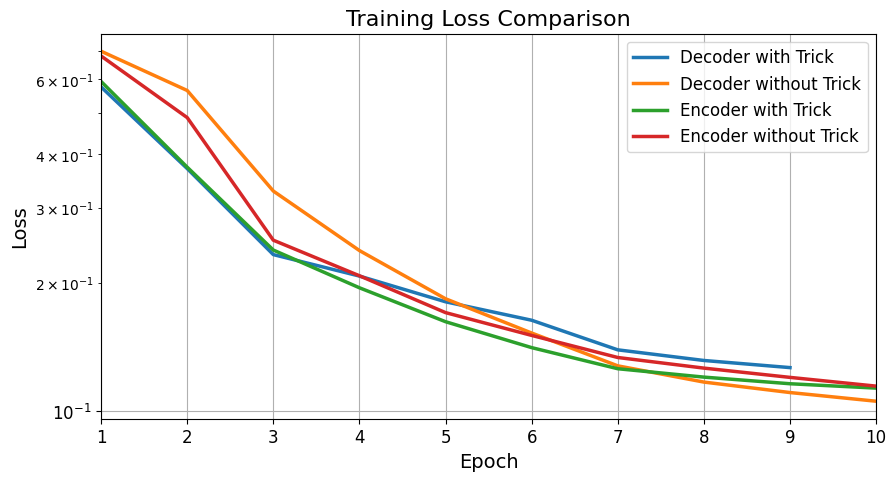

In [36]:
plt.figure(figsize=(10, 5))
plt.title("Training Loss Comparison", fontsize=16)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.xlim(1, 10)
plt.plot(df1["epoch"], df1["train_loss"], label="Decoder with Trick", linewidth=2.5)
plt.plot(df4["epoch"], df4["train_loss"], label="Decoder without Trick", linewidth=2.5)
plt.plot(df3["epoch"], df3["train_loss"], label="Encoder with Trick", linewidth=2.5)
plt.plot(df2["epoch"], df2["train_loss"], label="Encoder without Trick", linewidth=2.5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.yscale("log")
plt.grid()
plt.show()

In [17]:
import os
from typing import Dict, List, Union

import numpy as np
import torch
import torch.distributed as dist
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             precision_score, recall_score, roc_auc_score)
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from transformers import AutoTokenizer

from ex_params import MAX_TEXT_LENGTH


def get_csv_paths(folder_path: str, recursive: bool = False) -> List[str]:
    if recursive:
        # Walk through all subdirectories
        file_paths = [
            os.path.join(root, file)
            for root, _, files in os.walk(folder_path)
            for file in files
            if file.endswith(".csv")
        ]
    else:
        # Get files in the root folder only
        file_paths = [
            os.path.join(folder_path, file)
            for file in os.listdir(folder_path)
            if file.endswith(".csv")
        ]

    return file_paths


class TextDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int]) -> None:
        """
        texts: list of texts.
        labels: list of labels for all samples.
        """
        self.texts = texts
        self.labels = labels

    def __len__(self) -> int:
        return len(self.texts)

    def __getitem__(self, idx: int) -> Dict[str, Union[str, int]]:
        text = self.texts[idx]
        label = self.labels[idx]

        return {"text": text, "label": label}


def collate_fn(
    batch: List[Dict[str, torch.tensor]], tokenizer: AutoTokenizer
) -> Dict[str, torch.tensor]:
    texts = [item["text"] for item in batch]
    labels = [item["label"] for item in batch]
    encodings = tokenizer(
        texts,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
        max_length=MAX_TEXT_LENGTH,
    )

    labels_padded = [
        torch.where(t == 0, torch.tensor(-100), torch.tensor(label))
        for t, label in zip(encodings["attention_mask"], labels)
    ]
    labels_padded = torch.cat(labels_padded)
    encodings["labels"] = labels_padded

    return encodings


def collate_fn_longest(
    batch: List[Dict[str, torch.tensor]], tokenizer: AutoTokenizer
) -> Dict[str, torch.tensor]:
    texts = [item["text"] for item in batch]
    labels = [item["label"] for item in batch]
    encodings = tokenizer(
        texts,
        truncation=True,
        padding="longest",
        return_tensors="pt",
    )

    labels_padded = [
        torch.where(t == 0, torch.tensor(-100), torch.tensor(label))
        for t, label in zip(encodings["attention_mask"], labels)
    ]
    labels_padded = torch.stack(labels_padded)
    encodings["labels"] = labels_padded

    return encodings


In [8]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B-Instruct")
tokenizer.pad_token = "<|finetune_right_pad_id|>"
tokenizer.padding_side = "left"

In [9]:
train_dataset = TextDataset(df1["text"].tolist(), df1["label"].tolist())

In [35]:
train_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    collate_fn=lambda batch: collate_fn_longest(batch, tokenizer),
)

In [36]:
for batch in tqdm(train_loader):
    break

  0%|          | 0/40700 [00:00<?, ?it/s]


In [37]:
batch["input_ids"].shape, batch["labels"].shape, batch["attention_mask"].shape

(torch.Size([4, 149]), torch.Size([4, 149]), torch.Size([4, 149]))

In [39]:
batch["labels"].view(-1)

tensor([-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100,
        -100, -100, -100,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,   